# STX ML
To install:
```
mkvirtualenv venv-ml
workon venv-ml
pip install -r requirements.txt
pip install -r requirements_ml.txt
```
Based on code from https://github.com/Kulbear/stock-prediction

In [1]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import stxcal 
from stxts import StxTS 

Using TensorFlow backend.
stxcal.py:17: FutureWarning: pandas.core.datetools.Timedelta is deprecated. Please use pandas._libs.tslib.Timedelta instead.
  pd.datetools.Timedelta(weeks=52)


Initializing calendar between 1901-01-01 and 2019-12-25


## Import data
Start with one stock: MSFT; adjust for splits

In [18]:
stk = 'MSFT'
sd = '1960-01-01'
ed = stxcal.current_date()
ts = StxTS(stk, sd, ed)
dt = str(ts.df.index[ts.l - 1].date())
ts.set_day(dt)

8244

In [19]:
ts.df['open_interest'] = ts.df['c'] * ts.df['volume']
ts.df = ts.df[['o', 'hi', 'lo', 'volume', 'open_interest', 'c']]
ts.df.head()

,o,hi,lo,volume,open_interest,c
1986-03-13,0.079994,0.089993,0.079994,1.151131e+06,97190.94,0.084431
1986-03-14,0.084431,0.089993,0.084431,3.446672e+05,31017.60,0.089993
1986-03-17,0.089993,0.095555,0.089993,1.488118e+05,13392.00,0.089993
1986-03-18,0.089993,0.095555,0.089993,7.424587e+04,6681.60,0.089993
1986-03-19,0.089993,0.089993,0.084431,5.376425e+04,4838.40,0.089993


Normalize the data prior to feeding into model

In [20]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    return X_train, X_test, preprocessor

Split the data intoX_train, y_train, X_test, y_test

In [21]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
    result = np.array(result)
    row = round(0.95 * result.shape[0])
    train = result[: int(row), :]
    
    train, result, preprocessor = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test, preprocessor]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Connected(Dense)

In [81]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.35))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.25))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [82]:
window = 10
X_train, y_train, X_test, y_test, preprocessor = preprocess_data(ts.df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (7822, 10, 6))
('y_train', (7822,))
('X_test', (412, 10, 6))
('y_test', (412,))


In [83]:
model = build_model([X_train.shape[2], window, 100, 1])

/home/cma/.envs/venv-ml/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/cma/.envs/venv-ml/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=True, input_shape=(None, 6))`
  


('Compilation Time : ', 0.017663955688476562)


/home/cma/.envs/venv-ml/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


## Training the Network

In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=200,
    validation_split=0.1,
    verbose=1)

Train on 7039 samples, validate on 783 samples
Epoch 1/200
7039/7039 [==============================] - 3s 359us/step - loss: 0.2265 - acc: 0.0000e+00 - val_loss: 1.3394 - val_acc: 0.0000e+00
Epoch 2/200
7039/7039 [==============================] - 1s 125us/step - loss: 0.0303 - acc: 0.0000e+00 - val_loss: 0.8660 - val_acc: 0.0000e+00
Epoch 3/200
7039/7039 [==============================] - 1s 129us/step - loss: 0.0247 - acc: 0.0000e+00 - val_loss: 0.6198 - val_acc: 0.0000e+00
Epoch 4/200
7039/7039 [==============================] - 1s 126us/step - loss: 0.0257 - acc: 0.0000e+00 - val_loss: 0.6359 - val_acc: 0.0000e+00
Epoch 5/200
7039/7039 [==============================] - 1s 128us/step - loss: 0.0222 - acc: 0.0000e+00 - val_loss: 0.4054 - val_acc: 0.0000e+00
Epoch 6/200
7039/7039 [==============================] - 1s 129us/step - loss: 0.0243 - acc: 0.0000e+00 - val_loss: 0.5101 - val_acc: 0.0000e+00
Epoch 7/200
7039/7039 [==============================] - 1s 130us/step - loss: 0.02

Epoch 57/200
7039/7039 [==============================] - 1s 130us/step - loss: 0.0158 - acc: 0.0000e+00 - val_loss: 0.0687 - val_acc: 0.0000e+00
Epoch 58/200
7039/7039 [==============================] - 1s 131us/step - loss: 0.0132 - acc: 0.0000e+00 - val_loss: 0.1323 - val_acc: 0.0000e+00
Epoch 59/200
7039/7039 [==============================] - 1s 145us/step - loss: 0.0132 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 60/200
7039/7039 [==============================] - 1s 207us/step - loss: 0.0123 - acc: 0.0000e+00 - val_loss: 0.1754 - val_acc: 0.0000e+00
Epoch 61/200
7039/7039 [==============================] - 1s 163us/step - loss: 0.0141 - acc: 0.0000e+00 - val_loss: 0.0515 - val_acc: 0.0000e+00
Epoch 62/200
7039/7039 [==============================] - 1s 180us/step - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 0.1924 - val_acc: 0.0000e+00
Epoch 63/200
7039/7039 [==============================] - 1s 163us/step - loss: 0.0156 - acc: 0.0000e+00 - val_loss: 0.0765 

7039/7039 [==============================] - 1s 131us/step - loss: 0.0099 - acc: 0.0000e+00 - val_loss: 0.0282 - val_acc: 0.0000e+00
Epoch 114/200
7039/7039 [==============================] - 1s 129us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 115/200
7039/7039 [==============================] - 1s 127us/step - loss: 0.0104 - acc: 0.0000e+00 - val_loss: 0.0321 - val_acc: 0.0000e+00
Epoch 116/200
7039/7039 [==============================] - 1s 125us/step - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.0991 - val_acc: 0.0000e+00
Epoch 117/200
7039/7039 [==============================] - 1s 128us/step - loss: 0.0092 - acc: 0.0000e+00 - val_loss: 0.0313 - val_acc: 0.0000e+00
Epoch 118/200
7039/7039 [==============================] - 1s 126us/step - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0686 - val_acc: 0.0000e+00
Epoch 119/200
7039/7039 [==============================] - 1s 124us/step - loss: 0.0106 - acc: 0.0000e+00 - val_loss: 0.0297 - val_a

In [74]:
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

7813/7813 [==============================] - 2s 291us/step
Train Score: 0.43 MSE (0.65 RMSE)
411/411 [==============================] - 0s 345us/step
Test Score: 16.97 MSE (4.12 RMSE)


In [75]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [76]:
# TODO: Scale it back

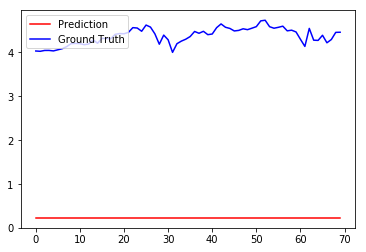

In [77]:
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt2

plt2.plot(pred[180:250], color='red', label='Prediction')
plt2.plot(y_test[180:250], color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()